In [115]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local


In [155]:
# Function to read the NDWI GeoTIFF image
def read_ndwi_image(image_path):
    with rasterio.open(image_path) as src:
        ndwi = src.read(1)  # Reading the first band (assume NDWI is in a single band)
        profile = src.profile  # Get the image metadata/profile
        ndwi[ndwi == src.nodata] = np.nan  # Replace NoData values with NaN
    return ndwi, profile

# Function to handle NaN values (replace them with a valid number)
def handle_nan_values(ndwi_image, fill_value=0):
    ndwi_clean = np.nan_to_num(ndwi_image, nan=fill_value)  # Replace NaN with a fill value (e.g., 0)
    return ndwi_clean

# Function to apply global Otsu and local thresholding
def apply_thresholds(ndwi_image, block_size=9999, offset=-0.08):
    # Step 1: Clean the NDWI image by handling NaN values
    ndwi_clean = handle_nan_values(ndwi_image)
    
    # Step 2: Normalize the NDWI image to the range 0-1
    ndwi_normalized = (ndwi_clean - np.min(ndwi_clean)) / (np.max(ndwi_clean) - np.min(ndwi_clean))
    
    # Step 3: Global Otsu thresholding
    global_thresh = threshold_otsu(ndwi_normalized)
    binary_global = ndwi_normalized > global_thresh
    
    # Step 4: Local thresholding
    local_thresh = threshold_local(ndwi_normalized, block_size=block_size, offset=offset)
    binary_local = ndwi_normalized > local_thresh
    
    return binary_global, binary_local, global_thresh, local_thresh

# Function to export the binary mask to a GeoTIFF
def export_binary_mask(mask, profile, output_path):
    # Update profile to match the binary mask data type (uint8)
    profile.update(dtype=rasterio.uint8, count=1, nodata=0)
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)  # Write the mask as uint8 (0 and 1)



input NDWI and calculate local and global OTSU 

In [157]:
# File path to your NDWI GeoTIFF image
image_path = "D:/River connectivity/NDWI-input for local OTSU code/Sep 2024 flood/22-9-2024.tif"
output_path_local = "D:/River connectivity/water mask OTSU-OUTPUT/Sep 2024 flood/watermask-22-9-2024.tif"  # Output file path for local threshold mask

# Step 1: Read the NDWI image
ndwi_image, profile = read_ndwi_image(image_path)

# Step 2: Apply global Otsu and local thresholding
block_size = 9999  # Size of the local neighborhood for thresholding
offset = -0.08    # Adjust the offset based on the image's contrast
binary_global, binary_local, global_thresh, local_thresh = apply_thresholds(ndwi_image, block_size, offset)


Show the orignal NDWI as well as local and global NDWI bands 

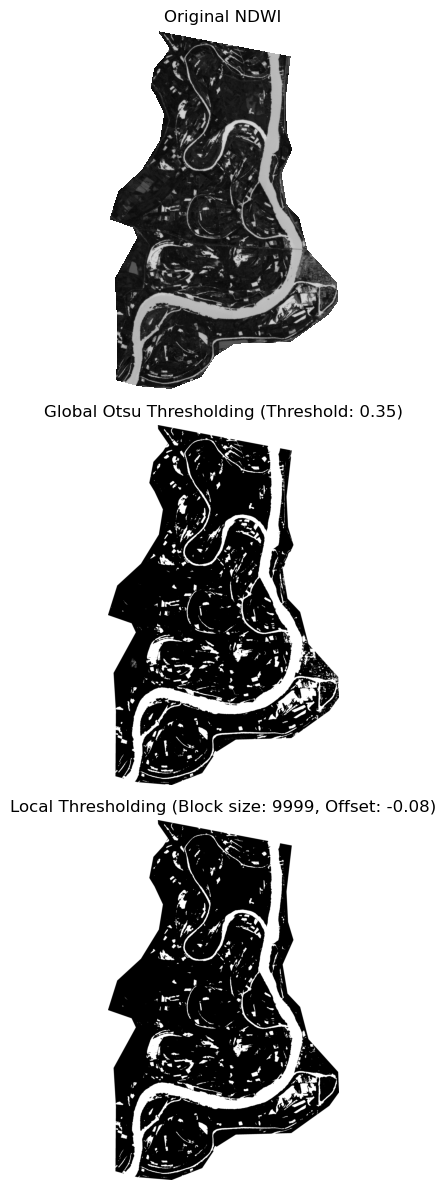

Local threshold water mask has been saved as GeoTIFF to D:/River connectivity/water mask OTSU-OUTPUT/Sep 2024 flood/watermask-22-9-2024.tif


In [159]:
# Step 4: Plot the results
fig, axes = plt.subplots(nrows=3, figsize=(10, 12))
ax = axes.ravel()

# Original NDWI image
ax[0].imshow(ndwi_image, cmap='gray')
ax[0].set_title('Original NDWI')

# Binary Global Otsu thresholding
ax[1].imshow(binary_global, cmap='gray')
ax[1].set_title(f'Global Otsu Thresholding (Threshold: {global_thresh:.2f})')

# Binary Local Thresholding
ax[2].imshow(binary_local, cmap='gray')
ax[2].set_title(f'Local Thresholding (Block size: {block_size}, Offset: {offset})')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

print(f"Local threshold water mask has been saved as GeoTIFF to {output_path_local}")

Export local mask to GeoTIFF

In [161]:
# Step 3: Export the local threshold mask to a GeoTIFF file
export_binary_mask(binary_local, profile, output_path_local)

Mask the resulted Local OTSU band to remove wrongly classified boundarires abnd cloud as water

In [163]:
import rasterio
import numpy as np

# Paths to the mask and the band files
mask_path = "D:/River connectivity/Raw images-Flood Sep 2024/22-9-2024_psscene_analytic_8b_sr_udm2/cloud and boundary mask.tif"
band_path = "D:/River connectivity/water mask OTSU-OUTPUT/Sep 2024 flood/watermask-22-9-2024.tif"
output_masked_band_path = "D:/River connectivity/water mask OTSU-OUTPUT/Sep 2024 flood/masked-watermask-22-9-2024.tif"

# Step 1: Open the mask file (reversed mask: 1 for valid, 0 for NaN)
with rasterio.open(mask_path) as mask_src:
    mask = mask_src.read(1)  # Read the mask (single band, binary: 1 for valid, 0 for NaN)

# Step 2: Open the band file 
with rasterio.open(band_path) as band_src:
    band = band_src.read(1)  # Read the specific band you want to mask (e.g., Green band)

    # Step 3: Apply the mask to the band (multiply the band by the mask)
    masked_band = band * mask  # This will set all NaN pixels (mask = 0) to 0 in the band

    # Step 4: Save the masked band to a new GeoTIFF file
    masked_band_meta = band_src.meta.copy()  # Copy metadata from the original band
    masked_band_meta.update(dtype=rasterio.float32, count=1)  # Update metadata for output

    with rasterio.open(output_masked_band_path, 'w', **masked_band_meta) as dst:
        dst.write(masked_band.astype(rasterio.float32), 1)  # Write masked band

print(f"Masked band saved to {output_masked_band_path}")


Masked band saved to D:/River connectivity/water mask OTSU-OUTPUT/Sep 2024 flood/masked-watermask-22-9-2024.tif
